<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_12/s12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download our code repository and install python dependencies

In [61]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git pull
!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torch_lr_finder"

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
fatal: destination path 'dl_hub' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports:

In [62]:
from __future__ import print_function
import os
import sys
sys.path.append("dl_hub/models")
sys.path.append("ERA_V1/session_12")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from dl_hub.models.custom_resnet import CustomResnet, model_summary

Lightning related imports

In [63]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy

Set up environment and add random seed

In [64]:
seed_everything(42)
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 512 if torch.cuda.is_available() else 64
NUM_WORKERS = 2

INFO:lightning_fabric.utilities.seed:Global seed set to 42


Define image augmentations using Albumentations. We use RandomCrop, HorizontalFlip, and cutout

In [65]:
train_transforms_a = A.Compose(
    [
        A.transforms.PadIfNeeded(min_height=40, min_width=40),
        AA.crops.transforms.RandomCrop(height=32, width=32),
        A.HorizontalFlip(p=0.5),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),
        ToTensorV2(),
        cifar10_normalization()
    ]
)
test_transforms_a = A.Compose([

    ToTensorV2(),
    cifar10_normalization()
])

Define Data transformations using Torch Transforms

In [66]:
train_transforms = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        cifar10_normalization()
    ]
)
test_transforms = transforms.Compose([

    transforms.ToTensor(),
    cifar10_normalization()
])

Define data module

In [67]:
cifar10_dm = CIFAR10DataModule(
    data_dir = PATH_DATASETS,
    batch_size = BATCH_SIZE,
    num_workers = NUM_WORKERS,
    train_transforms = train_transforms,
    test_transforms = test_transforms,
    val_transforms = test_transforms,
)

Let's build the Lightning ⚡ Module!

In [68]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.05, drop_out_probability=0.1, num_classes=10,
                 base_channels=3):
        super().__init__()

        self.save_hyperparameters()
        self.model = CustomResnet(base_channels=base_channels,
                                  num_classes=num_classes,
                                  drop_out_probability=drop_out_probability)

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        #loss = nn.CrossEntropyLoss(logits, y, reduction='mean')
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        #loss = nn.CrossEntropyLoss(logits, y, reduction='mean')
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y,"multiclass", num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_id):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(),
                               lr=self.hparams.lr,
                               weight_decay=1e-4)
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                4.65e-2,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
                pct_start = 5./self.trainer.max_epochs,
                div_factor=2000,
                three_phase=False,
                anneal_strategy='linear',
                verbose=False
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}


In [69]:
cifar10_dm

Initiate and train the model

In [70]:
drop_out_probability=0.01
model = LitResnet(lr=0.01,base_channels=3, num_classes=10,
                  drop_out_probability=drop_out_probability)

trainer = Trainer(
    max_epochs=24,
    accelerator='auto',
    devices = 1 if torch.cuda.is_available() else None,
    logger = CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval='step'),
               TQDMProgressBar(refresh_rate=10)])

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule = cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params
---------------------------------------
0 | model | CustomResnet | 6.6 M 
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.292    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/content/dl_hub/models/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8744999766349792     │
│         test_loss         │    0.37107735872268677    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.37107735872268677, 'test_acc': 0.8744999766349792}]

,lr-Adam,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.005271,NaN,NaN,NaN,NaN,NaN
0.0,NaN,1.390189,NaN,NaN,NaN,NaN
0.0,NaN,NaN,1.79243,0.4382,NaN,NaN
NaN,0.010625,NaN,NaN,NaN,NaN,NaN
1.0,NaN,1.212951,NaN,NaN,NaN,NaN


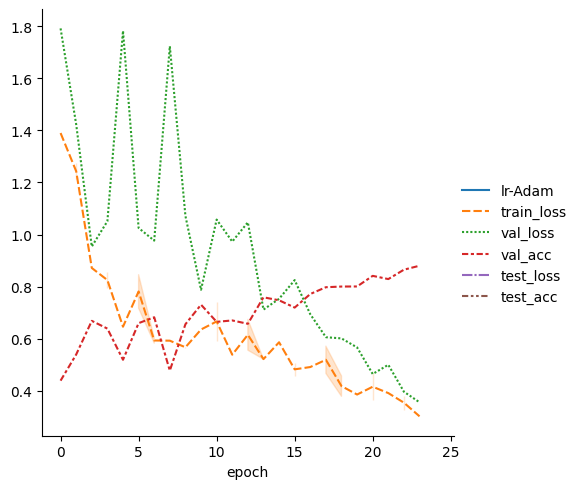

In [71]:
import pandas as pd
import seaborn as sn
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

Preview Augmentations


100%|██████████| 170498071/170498071 [00:12<00:00, 13237025.18it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


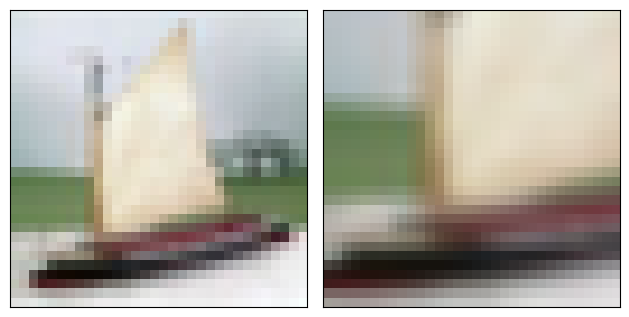

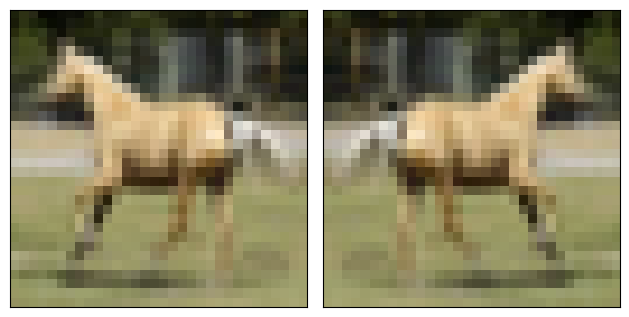

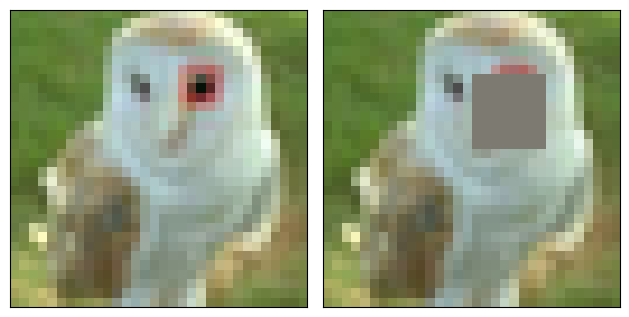

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def un_normalize_image(img):
    un_norm_transform = transforms.Compose([transforms.Normalize((0.,0.,0.,),(1./0.247,1./0.244,1./0.262)),
                                                 transforms.Normalize((-0.491,-0.482,-0.447),(1.0,1.0,1.0))])
    return un_norm_transform(img)

def preview_augmentations(train_loader, image_transform):
    batch_data, batch_label = next(iter(train_loader))
    preview_img = np.asarray(un_normalize_image(batch_data[0].squeeze()))
    preview_img = (preview_img*255./np.max(preview_img)).astype('uint8')
    preview_label = batch_label[0]
    fig, axs = plt.subplots(1, 2)
    plt.tight_layout()

    un_normalized_img = un_normalize_image(batch_data[0].squeeze())
    un_normalized_img = np.asarray(un_normalized_img)
    transformed_numpy_img = image_transform(image = un_normalized_img.transpose(1,2,0))["image"]
    axs[0].imshow(preview_img.transpose((1,2,0)))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(transformed_numpy_img)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    plt.tight_layout()
    plt.show()

# Reload train and test loader to preview augmentations
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
eg_train_loader, eg_test_loader, eg_class_names = load_cifar10_data(train_transforms= A.Compose([A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),ToTensorV2()]), test_transforms=A.Compose([A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),ToTensorV2()]), batch_size=32, **kwargs)

# Random Resized Crop
img_transforms = A.Compose([AA.crops.transforms.RandomResizedCrop(height= 32,width = 32,p=0.2)])
preview_augmentations(eg_train_loader, img_transforms)

# Horizontal Flip
img_transforms = A.Compose([A.HorizontalFlip(always_apply=True)])
preview_augmentations(eg_train_loader, img_transforms)

# Cut out
img_transforms = A.Compose([AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None, always_apply=True)])
preview_augmentations(eg_train_loader, img_transforms)



Show sample Images from the dataset

In [73]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

NameError: ignored

Train model using Batch Normalization

In [ ]:
drop_out = 0.02
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10,drop_out_probability=drop_out).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
max_lr = 4.65e-2
# Define scheduler
optim_obj.define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    lr_values.append(optim_obj.scheduler.get_lr())
    print(f"epoch: {epoch}\t learning rate: {optim_obj.scheduler.get_last_lr()[0]}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



Plot LR values

In [ ]:
import matplotlib.pyplot as plt
def plot_lr_values2(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    #plt.yscale('log')
    plt.show()

def plot_lr_values(scheduler, num_epochs, num_batches):
    lrs = []
    steps = []
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])
            steps.append(epoch * num_batches + batch)

    plt.figure()
    plt.legend()
    plt.plot(steps, lrs, label='OneCycle')
    plt.show()

def plot_losses(train_losses, test_losses):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    epochs = range(1,len(train_losses)+1)
    axs[0].plot(epochs, train_losses)
    axs[0].set_title("Train")
    axs[1].plot(epochs, test_losses)
    axs[1].set_title("Test")

def plot_accuracy(train_acc, test_acc, target_test_acc = 90.):
    epochs = range(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epochs, train_acc, epochs, test_acc)
    plt.axhline(target_test_acc, color='r')
    plt.legend(('Train','Test'),loc='best')
    plt.title("Accuracy")


Plot results for Batch Norm experiment

In [ ]:
this_scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=200,
        three_phase=False,
        #final_div_factor=1000,
        anneal_strategy='linear',
        verbose=False
        )
plot_lr_values(this_scheduler, num_epochs, len(train_loader))
plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)


Print Training Log

In [ ]:
print_train_log(train_acc, test_acc, train_losses, test_losses)